# Trabajo Final

El protocolo experimental que implementamos tiene 2 datasets:

1. Dataset de las señales de EEG
2. El video de las imágenes.

La idea es tomar estos datasets y derivar de forma automática las diferentes secciones.

Esto se puede hacer en base self-supervised, es decir tomar los datos de algún dataset, derivar los labels para cada secciones y luego intentar implementar un clasificador multiclase.

Tienen que entregar un PDF, tipo Markdown con código, gráficos y cualquier insight obtenido del dataset.


In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import butter, lfilter
from datetime import timedelta

### Utils

In [256]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def plot_signal(df: pd.DataFrame):
    """
    Plots `eeg`, `meditation` and `attention` in both time and frequency domains,
    for the given DataFrame.

    Applies `rfft()` to the 3 signals to calculate the frequency spectrum.

    Arguments:
        df: DataFrame with the signals
    """
    df.loc[:, "unix_timestamp_diff"] = df.unix_timestamp - df.unix_timestamp.min()

    ticks = np.linspace(0, df["unix_timestamp_diff"].max(), 10).astype(int)

    _, ax = plt.subplots(
        nrows=3,
        ncols=2,
        sharex='col',
        **{"figsize": (12, 6), "dpi": 125, "facecolor": "white"}
    )

    WIDTH = 0.75

    # Column 1: Time-based plots

    ax[0, 0].plot(
        df.unix_timestamp_diff,
        df.eeg,
        color='steelblue',
        linewidth=WIDTH
    )
    ax[0, 0].set_ylabel('eeg(t)')
    ax[0, 0].set_title('EEG Signals')

    ax[1, 0].plot(
        df.unix_timestamp_diff,
        df.meditation,
        color='lightgreen', 
        linewidth=WIDTH
    )
    ax[1, 0].set_ylabel('meditation(t)')

    ax[2, 0].plot(
        df.unix_timestamp_diff,
        df.attention,
        color='orange',
        linewidth=WIDTH
    )
    ax[2, 0].set_ylabel('attention(t)')

    ax[2, 0].set_xticks(ticks)
    ax[2, 0].set_xlabel("t [s]")
    
    # Column 2: Frequency-based plots
    N = len(df)
    SAMPLE_RATE = 512

    xf = rfftfreq(N, 1 / SAMPLE_RATE)

    yf_eeg        = butter_bandpass_filter(rfft(df.eeg), 5, 50, fs=512)
    yf_meditation = butter_bandpass_filter(rfft(df.meditation), 5, 50, fs=512)
    yf_attention  = butter_bandpass_filter(rfft(df.attention), 5, 50, fs=512)

    ax[0, 1].plot(
        xf[:len(xf) // 5],
        np.abs(yf_eeg)[:len(xf) // 5],
        color='steelblue',
        linewidth=WIDTH
    )
    ax[0, 1].set_ylabel('eeg(f)')
    ax[0, 1].set_title('EEG Signal Spectrum')

    ax[1, 1].plot(
        xf[:len(xf) // 5],
        np.abs(yf_meditation)[:len(xf) // 5],
        color='lightgreen', 
        linewidth=WIDTH
    )
    ax[1, 1].set_ylabel('meditation(f)')

    ax[2, 1].plot(
        xf[:len(xf) // 5],
        np.abs(yf_attention)[:len(xf) // 5],
        color='orange',
        linewidth=WIDTH
    )
    ax[2, 1].set_xlabel("f [Hz]")
    ax[2, 1].set_ylabel('attention(f)')
    
    plt.tight_layout()

    plt.show()

## Read the data

In [257]:
signals = pd.read_csv('data/tpfinal/eeg.dat', delimiter=' ', names = ['timestamp','counter','eeg','attention','meditation','blinking'])

signals.head()

,timestamp,counter,eeg,attention,meditation,blinking
0,1.655925e+09,68,32,0,0,0
1,1.655925e+09,69,40,0,0,0
2,1.655925e+09,70,42,0,0,0
3,1.655925e+09,71,34,0,0,0
4,1.655925e+09,72,24,0,0,0


### Some preprocessing to start labelling

Hay 0 days 00:10:59.950000 minutos de data


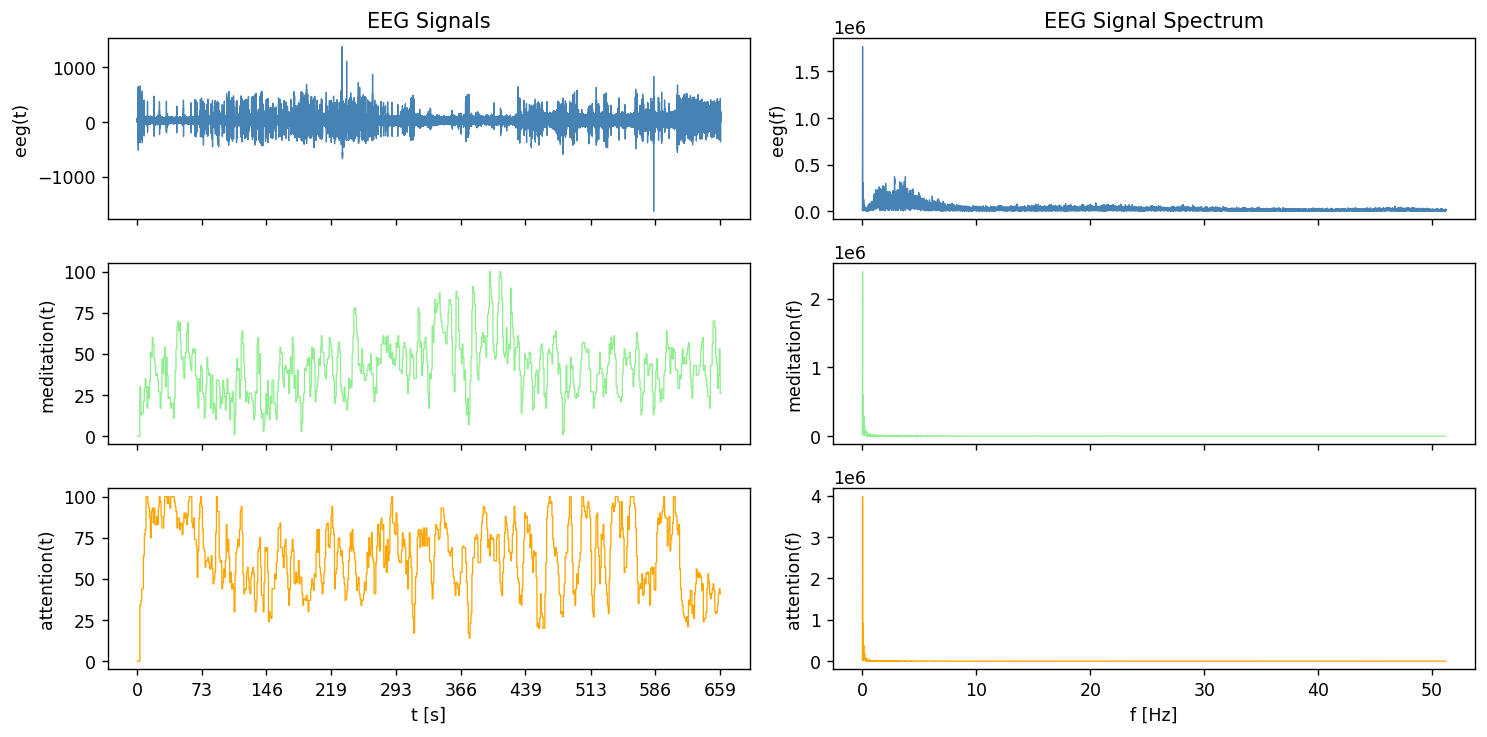

In [258]:
from datetime import datetime

signals["unix_timestamp"] = signals["timestamp"]
signals["timestamp"] = signals["unix_timestamp"].map(datetime.fromtimestamp)

signals.sort_values(by="timestamp", inplace=True, ignore_index=True)

signals["label"] = None

signals_copy = signals.copy(deep=True)

print(f"Hay {signals.timestamp.max() - signals.timestamp.min()} minutos de data")

plot_signal(signals)

### Labelling

This notebook labels records incrementally from the beginning to the end. We have to declare *how long* each section lasts, starting from the end of the previous section.

Example:

_NOTE: Consider that `signals` is a dataframe with the entire information (sorted by time)._

---- 

Looking at the video, from 00:00 to 00:10 the person is _blinking_, therefore we have to define a `delta = 10 seconds` and `label = blinking`.

The code will pick the first `delta` of data from the signals, separate it and label it as `label`.

Now, such "section" has been removed from signals, so the next time we have to define a `delta` RELATIVE to this point.



From 00:21 to 01:40 the person might be _coffing_, so we define `delta = 1 min 19 seconds` and `label = coffing`.

And so on...



In [260]:
labeled_signals = None

def label_records(
    label: str, 
    delta: timedelta
):
    """
    This function is intended to work incrementally based on the prior execution.
    
    It performs the following steps:

    - Grabs the first N records of `signals` with `timestamp` less than or equal to
      the `signals.timestamp.min() + delta`
      - Since signals is sorted by timestamp, we grab (incrementally) records to treat as aa new section
    
    - Labels the records with `label`
    - Plot that section of the signals for better understanding

    - Removes the records from the original `signals` file for the next iteration
    """
    global signals

    signals_to_label = signals.loc[signals.timestamp <= signals.timestamp.min() + delta]

    signals_to_label.loc[:, "label"] = label

    plot_signal(signals_to_label)

    global labeled_signals

    if labeled_signals is None:
        labeled_signals = signals_to_label

    else:
        labeled_signals = pd.concat(
            [
                labeled_signals,
                signals_to_label
            ]
        )

    signals = signals.loc[~signals.index.isin(labeled_signals.index)]

### Desde 00:10 hasta 00:19: **blinking**

Before labelling - signals (339301, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


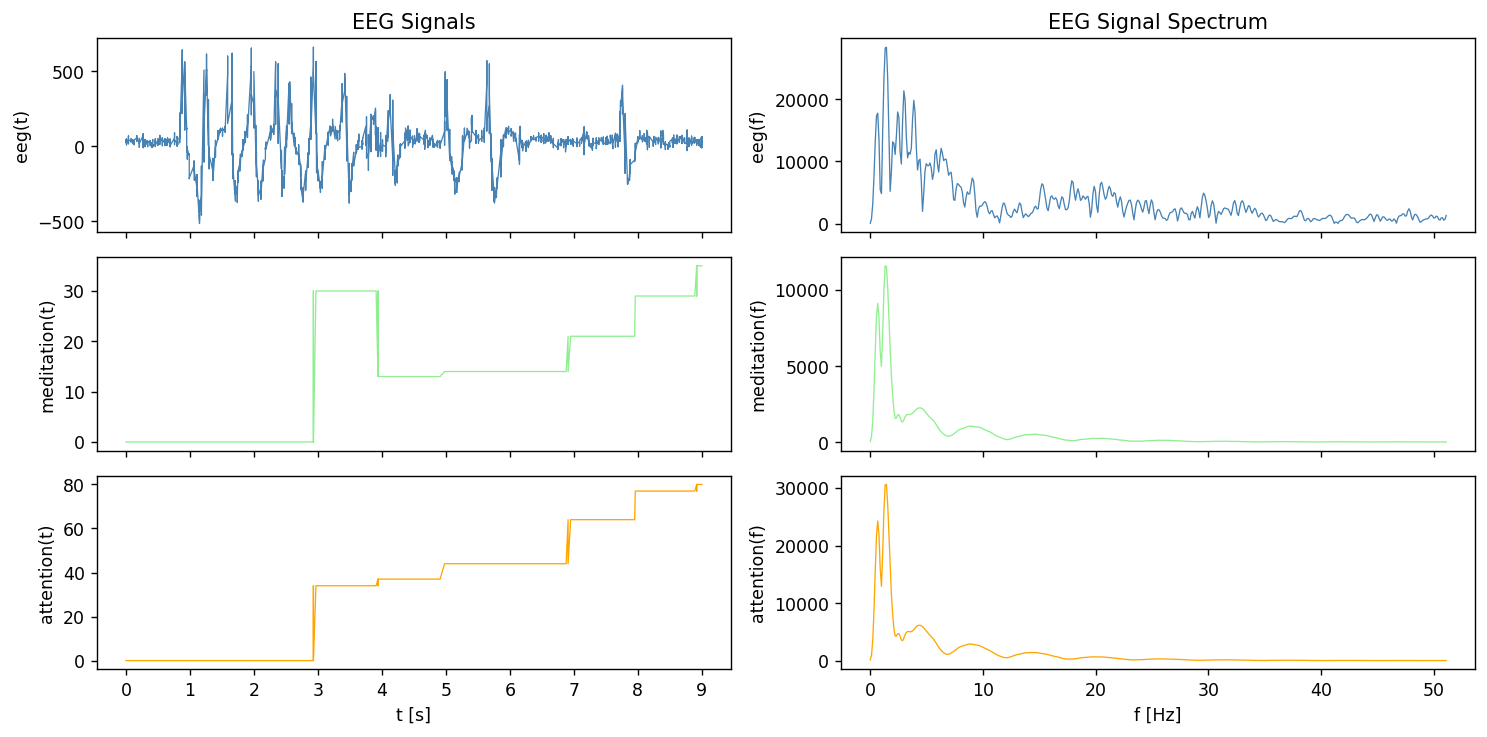

After labelling - signals (334661, 9) | labeled (4640, 9)


In [261]:
print(f"Before labelling - signals {signals.shape}")

label_records(label="blinking", delta=timedelta(seconds=9))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 00:20 hasta 01:28: **baseline**

Before labelling - signals (334661, 9) | labeled (4640, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


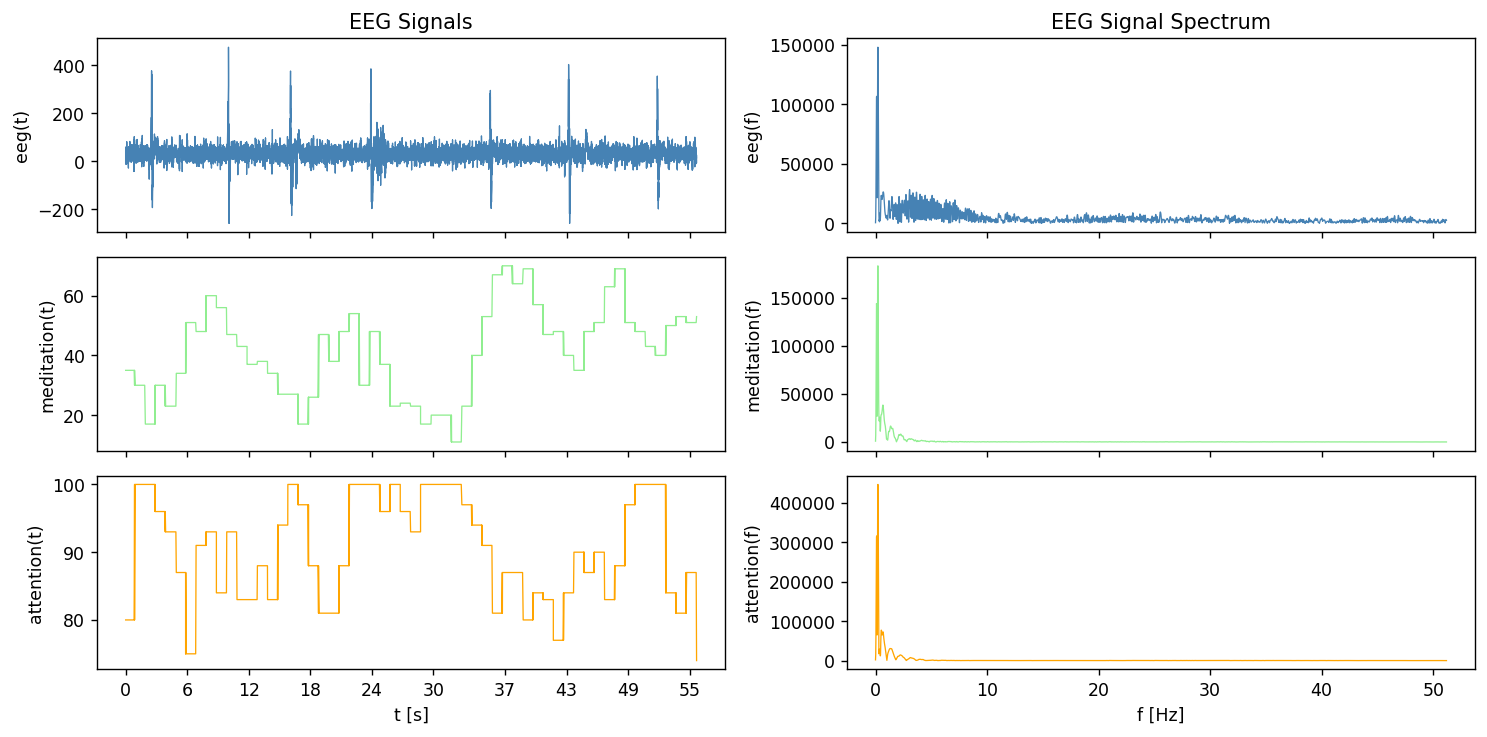

After labelling - signals (306023, 9) | labeled (33278, 9)


In [262]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="baseline", delta=timedelta(seconds=55, milliseconds=700))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 01:30 a 01:34: **blinking**

Before labelling - signals (306023, 9) | labeled (33278, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


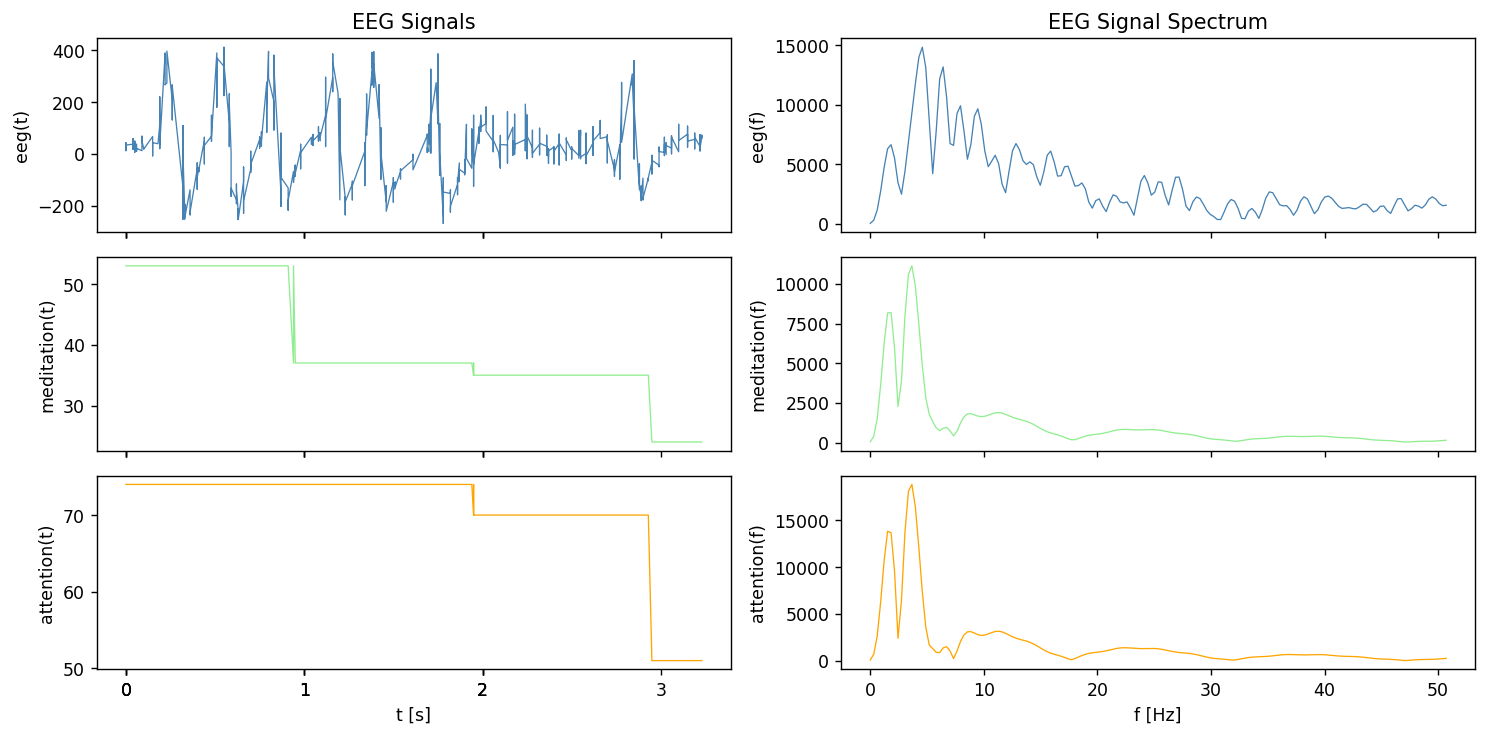

After labelling - signals (304347, 9) | labeled (34954, 9)


In [263]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="blinking", delta=timedelta(seconds=3, milliseconds=250))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 01:30 a 02:54: **Tos**

Before labelling - signals (304347, 9) | labeled (34954, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


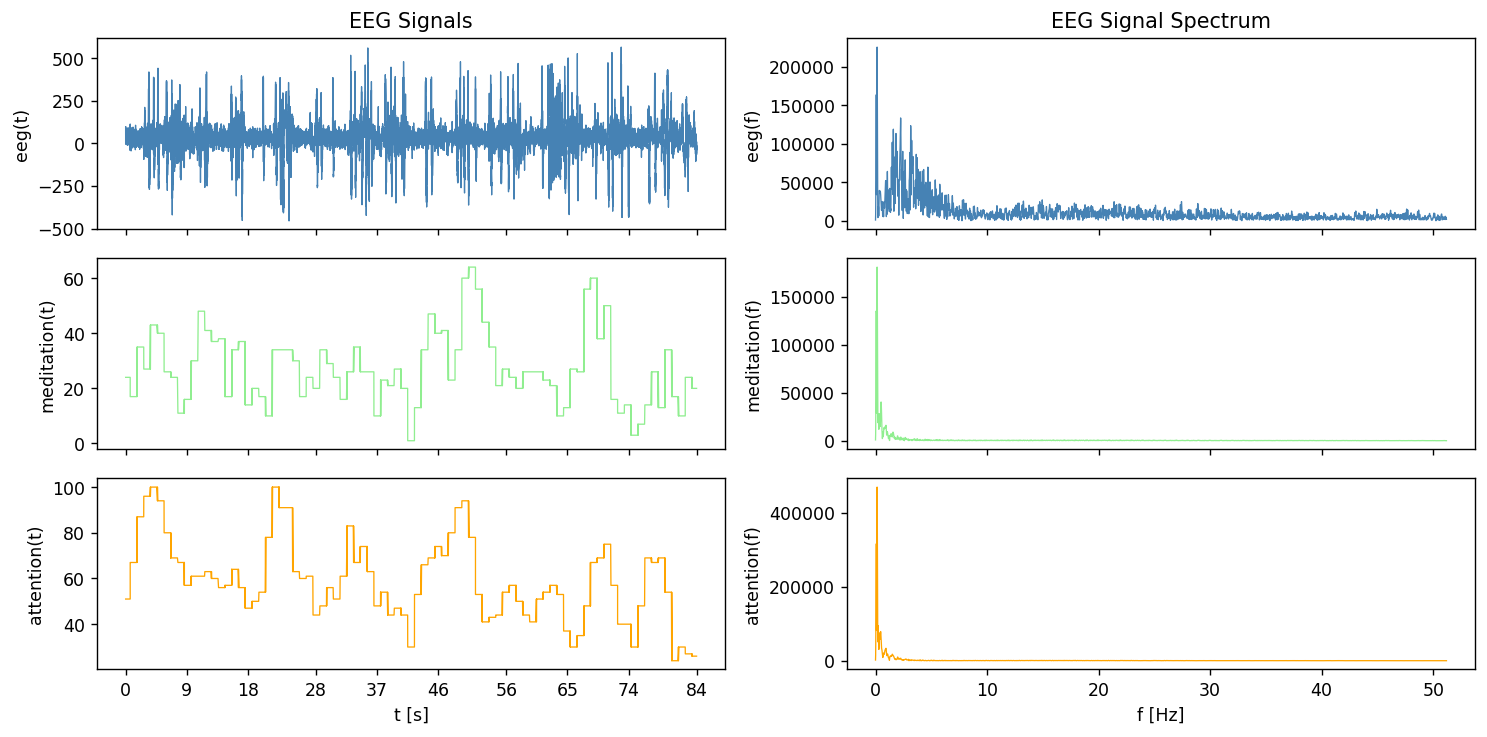

After labelling - signals (261145, 9) | labeled (78156, 9)


In [264]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="tos", delta=timedelta(minutes=1, seconds=24))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 02:55 a 04:07: **Respira hondo**

Before labelling - signals (261145, 9) | labeled (78156, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


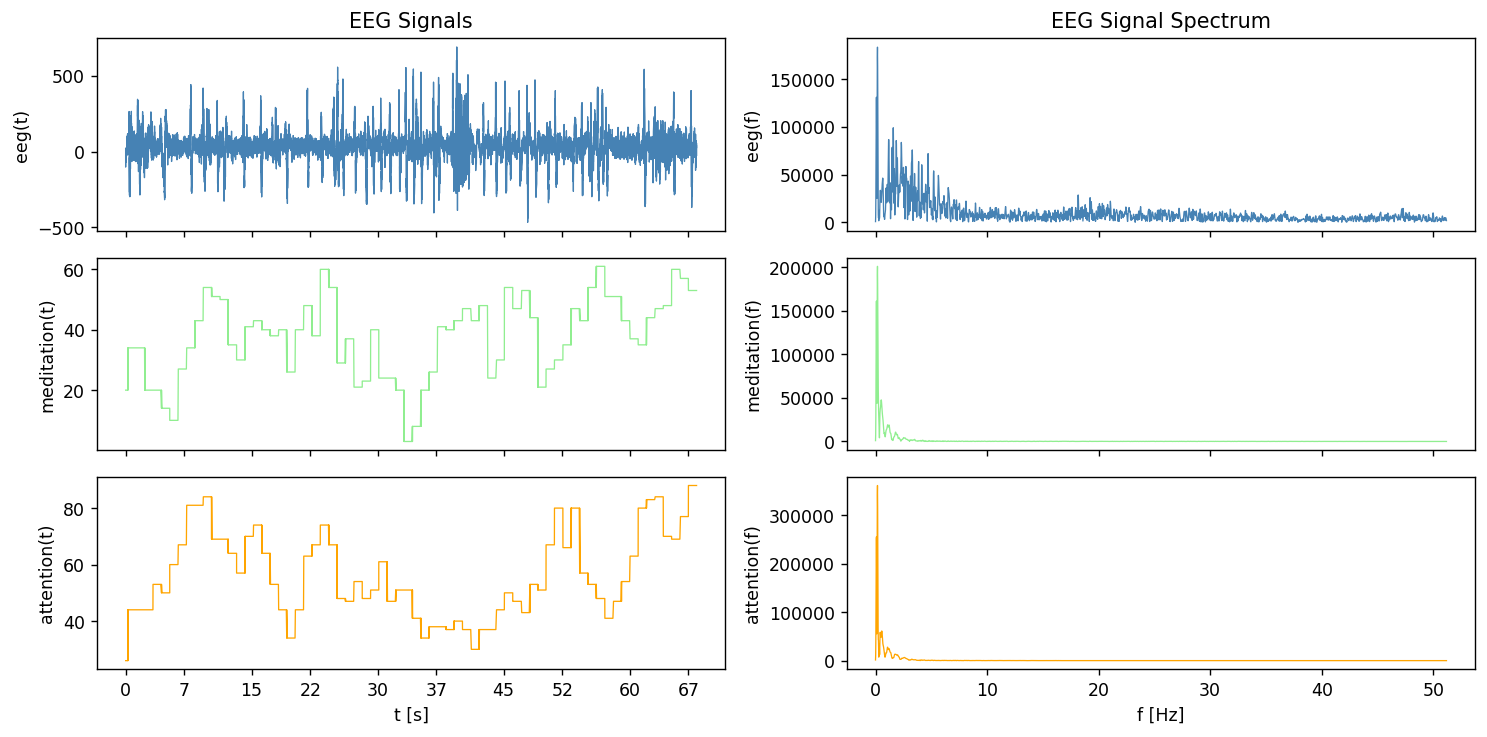

After labelling - signals (226171, 9) | labeled (113130, 9)


In [265]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="respira_hondo", delta=timedelta(minutes=1, seconds=8))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 04:08 a 04:11: **Blinking**

Before labelling - signals (226171, 9) | labeled (113130, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


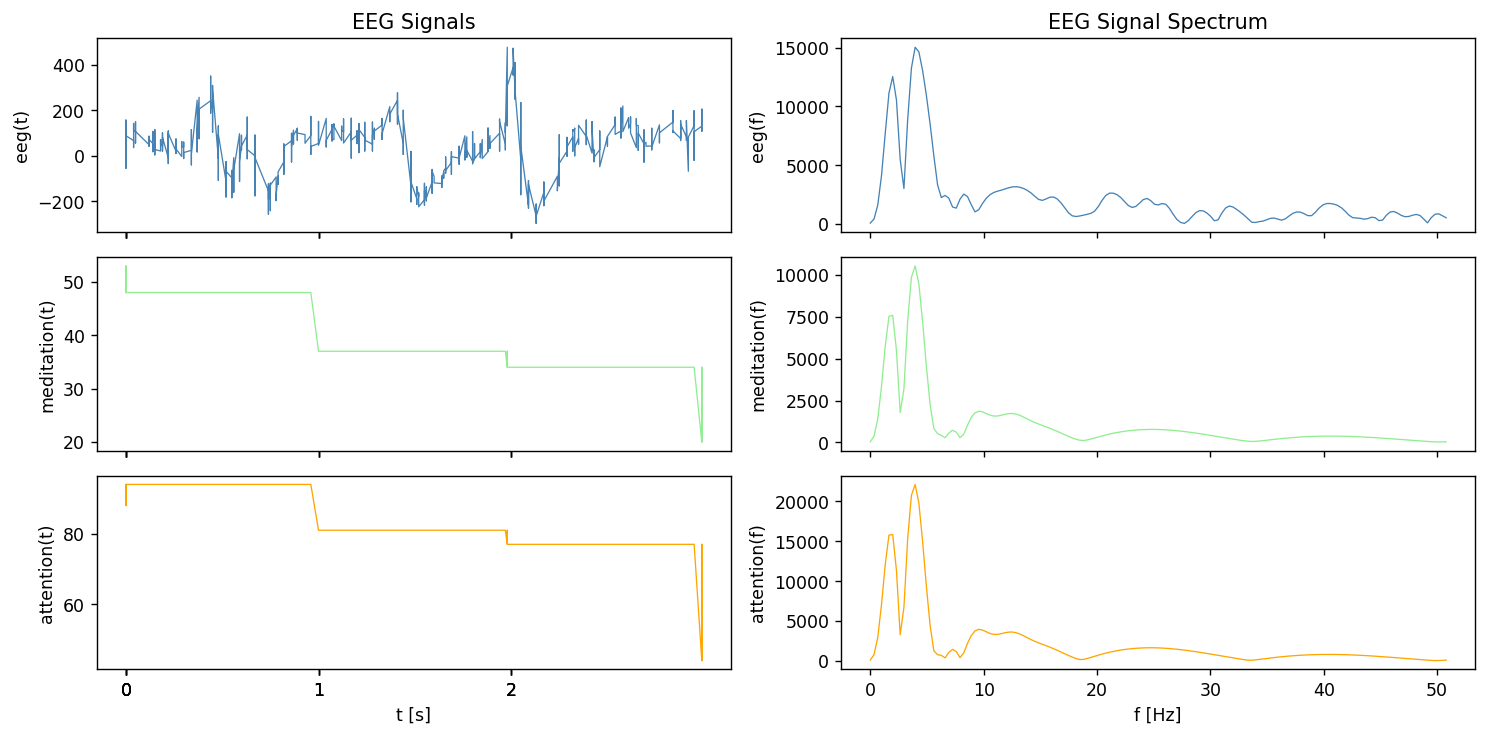

After labelling - signals (224619, 9) | labeled (114682, 9)


In [266]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="blinking", delta=timedelta(seconds=3))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 04:12 a 05:19: **Respira rápido**

Before labelling - signals (224619, 9) | labeled (114682, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


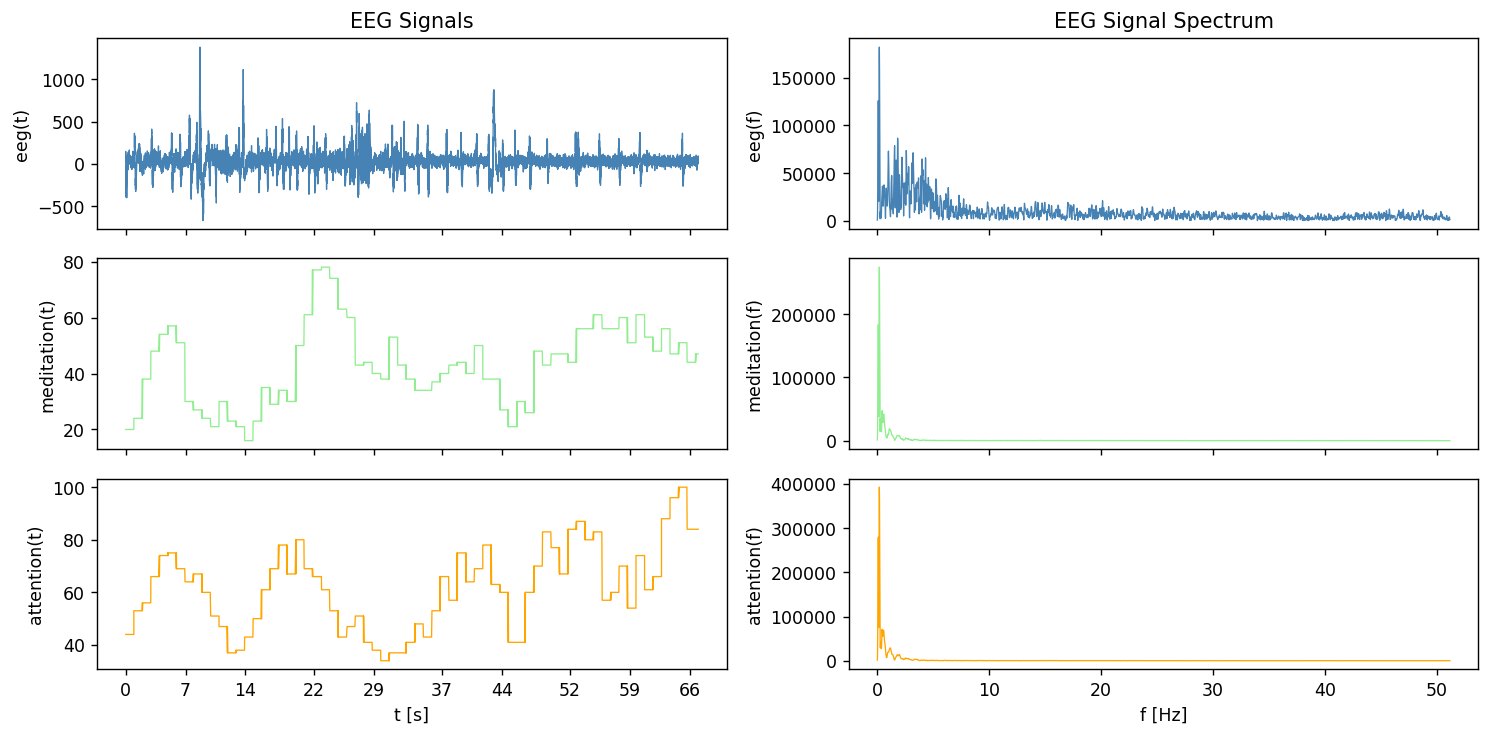

After labelling - signals (190160, 9) | labeled (149141, 9)


In [267]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="respira_rapido", delta=timedelta(minutes=1, seconds=7))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 05:19 a 05:23: **Blinking**

Before labelling - signals (190160, 9) | labeled (149141, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


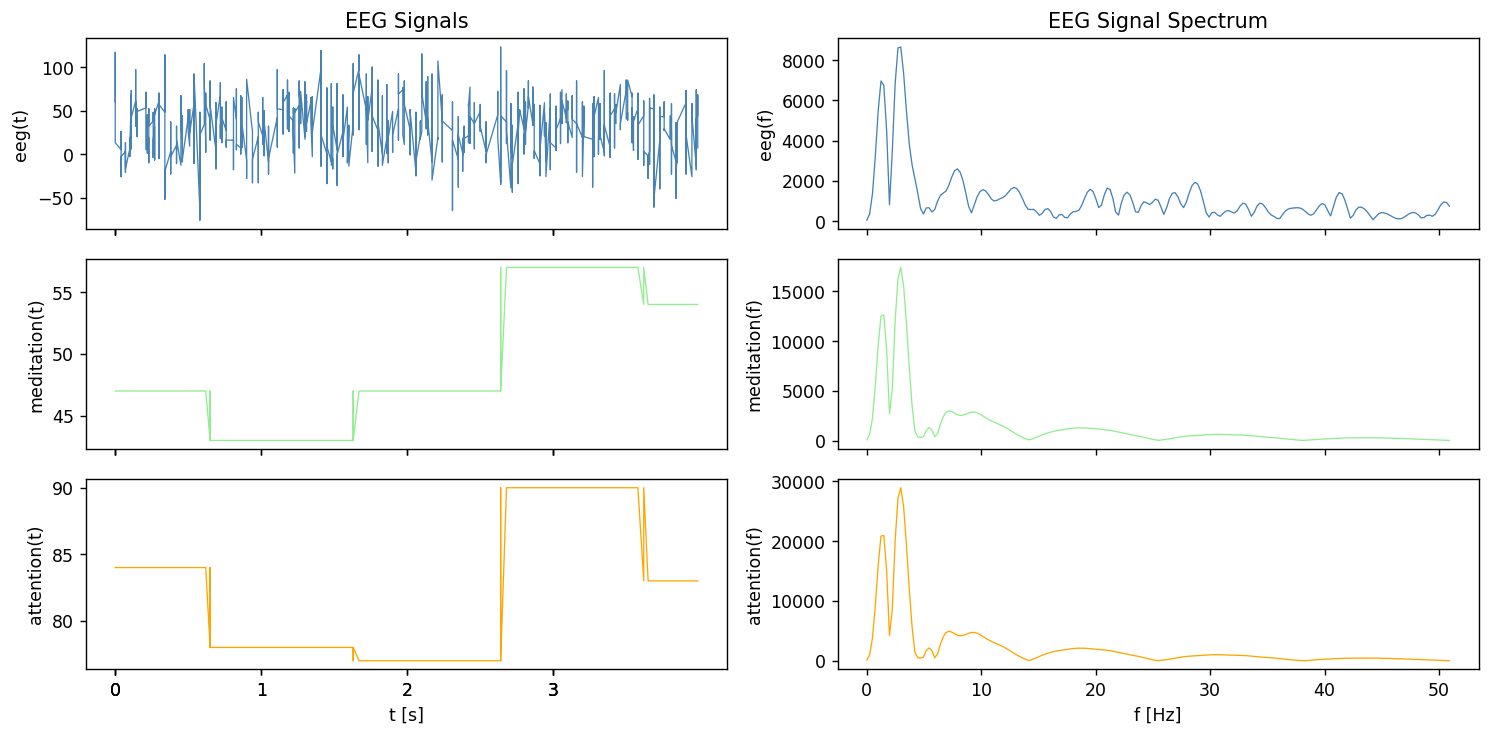

After labelling - signals (188088, 9) | labeled (151213, 9)


In [268]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="blinking", delta=timedelta(seconds=4))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 05:24 a 06:34: **Cuenta mental**

Before labelling - signals (188088, 9) | labeled (151213, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


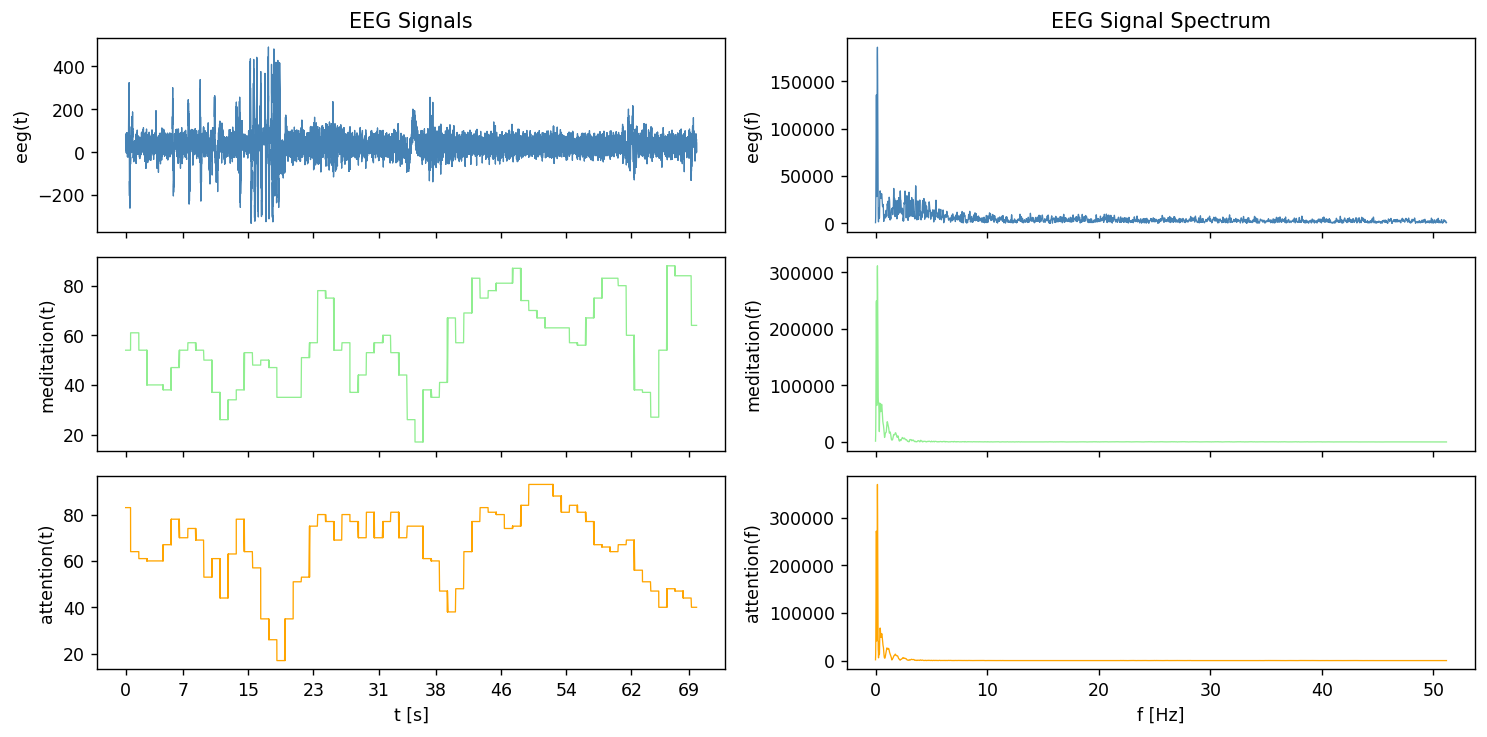

After labelling - signals (152093, 9) | labeled (187208, 9)


In [269]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="cuenta_mental", delta=timedelta(minutes=1, seconds=10))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 06:35 a 06:39: **Blinking**

Before labelling - signals (152093, 9) | labeled (187208, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


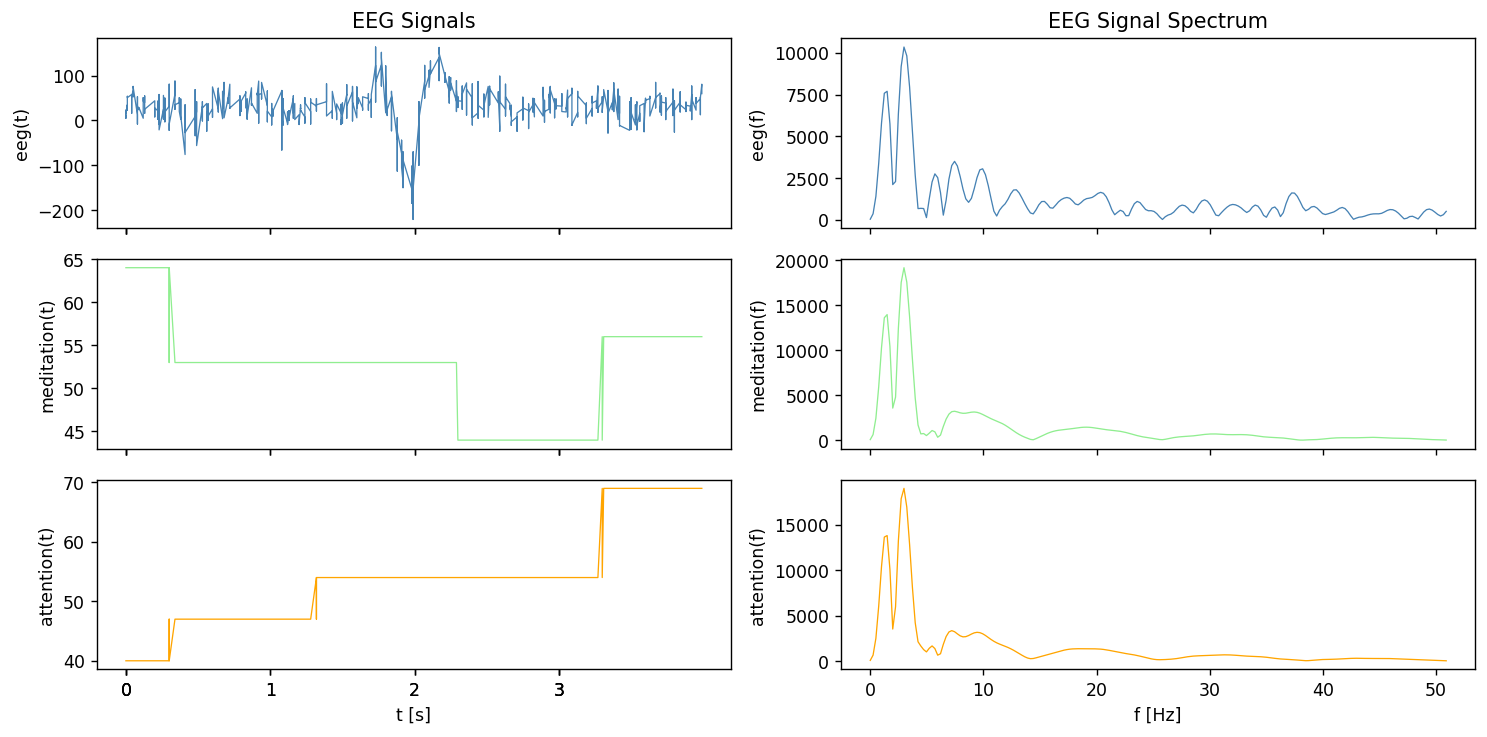

After labelling - signals (150031, 9) | labeled (189270, 9)


In [270]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="cuenta_mental", delta=timedelta(seconds=4))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 06:40 a 07:50: **Colores**

Before labelling - signals (150031, 9) | labeled (189270, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


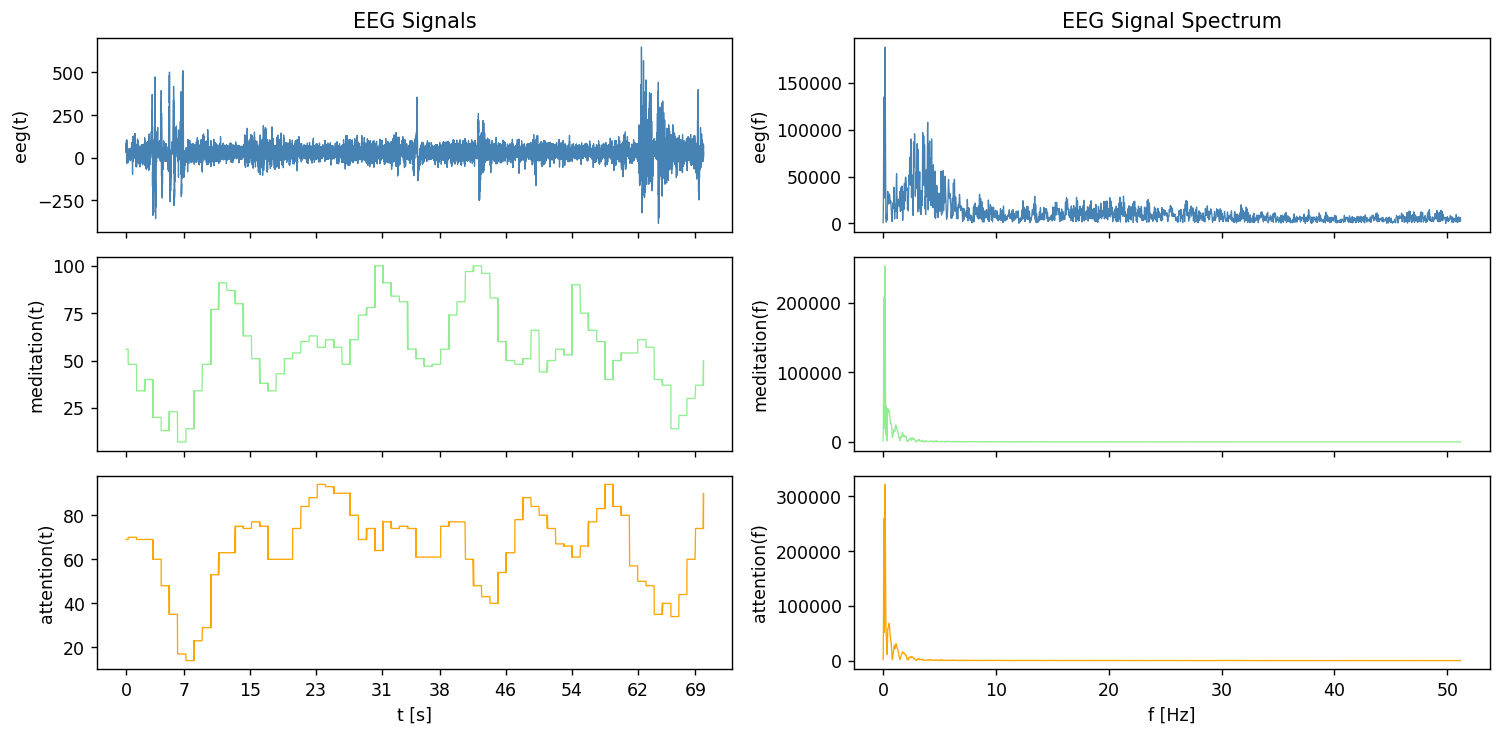

After labelling - signals (114031, 9) | labeled (225270, 9)


In [271]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="colores", delta=timedelta(minutes=1, seconds=10))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 07:50 a 07:53: **Baseline**

Before labelling - signals (114031, 9) | labeled (225270, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


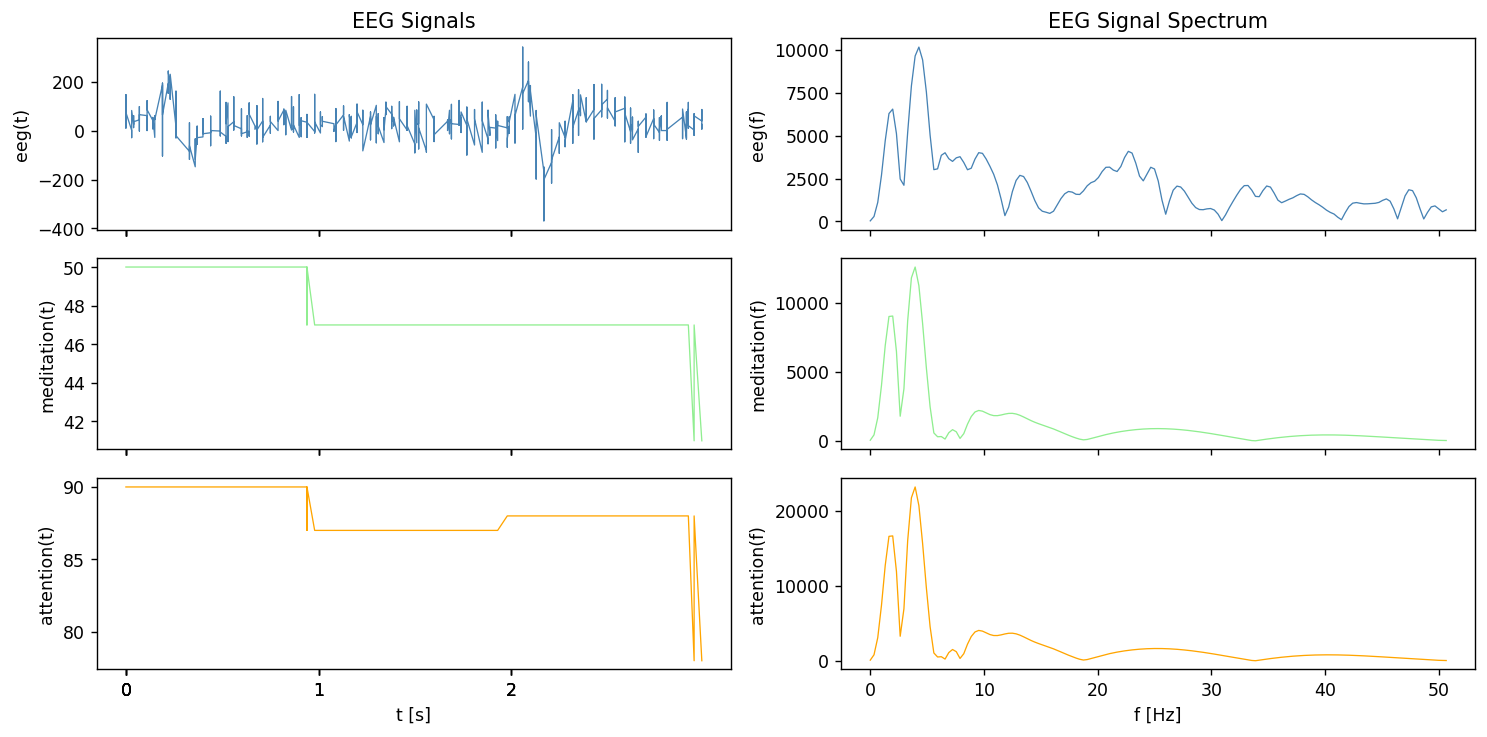

After labelling - signals (112474, 9) | labeled (226827, 9)


In [272]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="baseline", delta=timedelta(seconds=3))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 07:54 a 09:04: **Otro color?**

Before labelling - signals (112474, 9) | labeled (226827, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


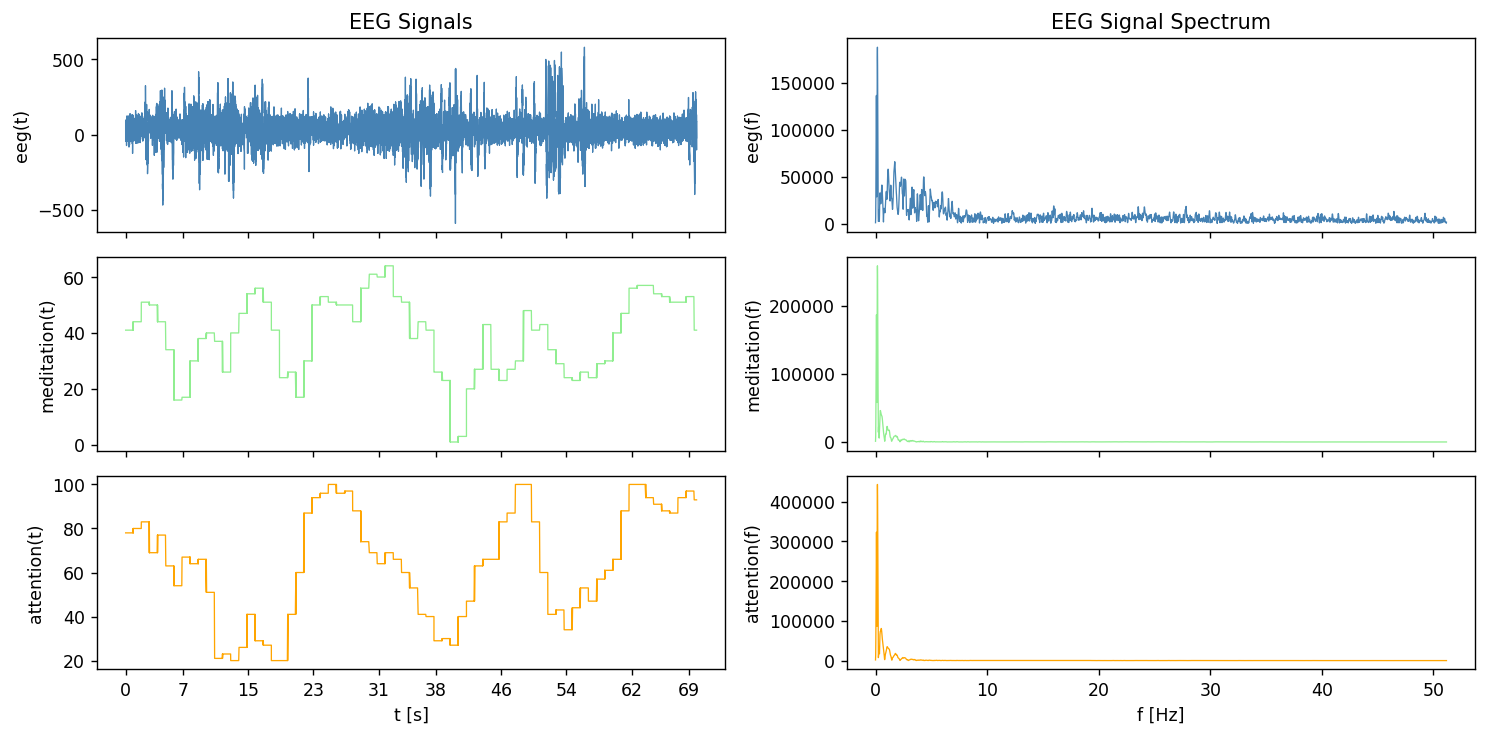

After labelling - signals (76499, 9) | labeled (262802, 9)


In [249]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="colores_2", delta=timedelta(minutes=1, seconds=10))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 09:05 a 09:06: **Blinking**

Before labelling - signals (76499, 9) | labeled (262802, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


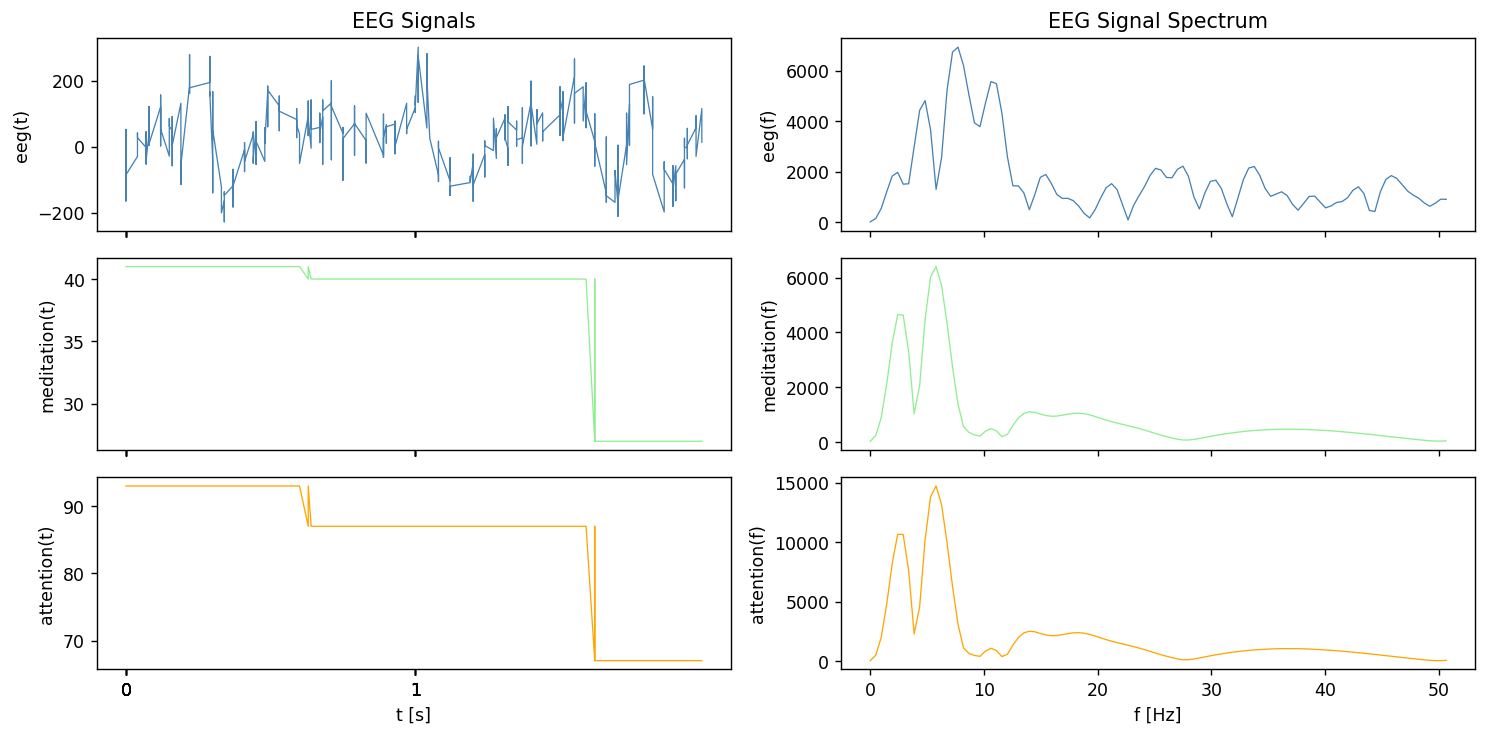

After labelling - signals (75438, 9) | labeled (263863, 9)


In [250]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="colores_2", delta=timedelta(seconds=2))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 09:07 a 10:20: **Sonrisa**

Before labelling - signals (75438, 9) | labeled (263863, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


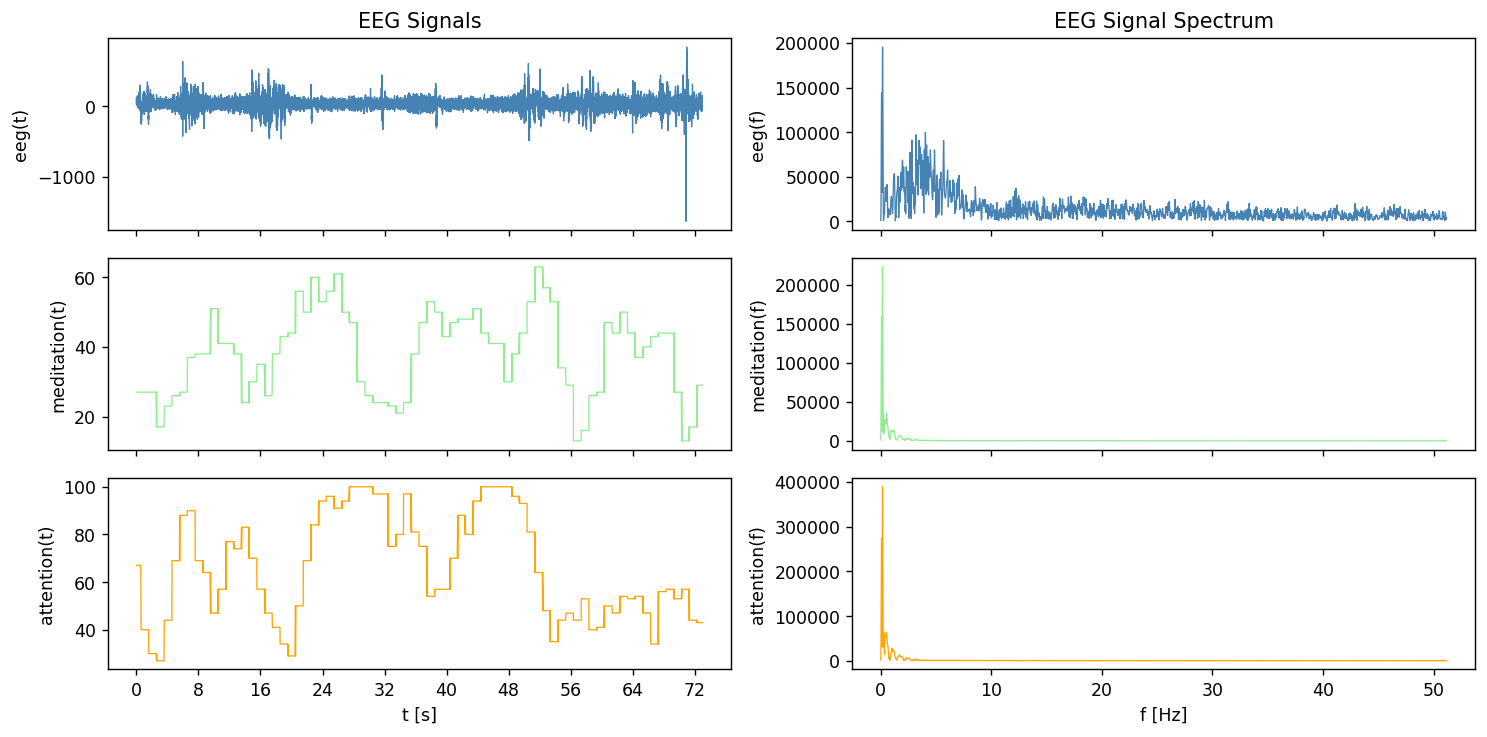

After labelling - signals (37907, 9) | labeled (301394, 9)


In [251]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="sonrisa", delta=timedelta(minutes=1, seconds=13))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 10:21 a 10:23: **Blinking**

Before labelling - signals (37907, 9) | labeled (301394, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


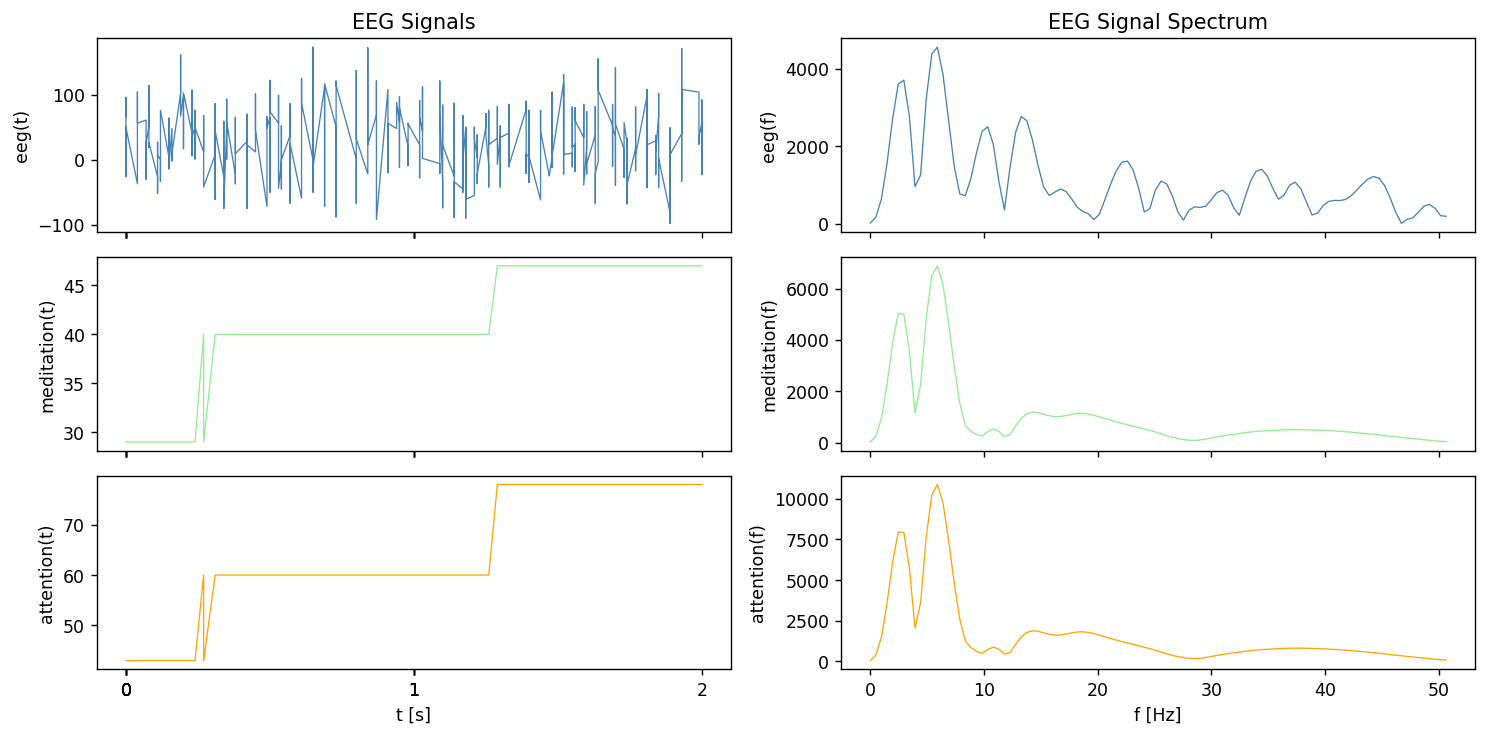

After labelling - signals (36866, 9) | labeled (302435, 9)


In [252]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="blinking", delta=timedelta(seconds=2))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### 10:24 a 12:47: **Pensamientos agradables/desagradables**

Before labelling - signals (36866, 9) | labeled (302435, 9)


/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/facundopalavecino/opt/anaconda3/envs/mne3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


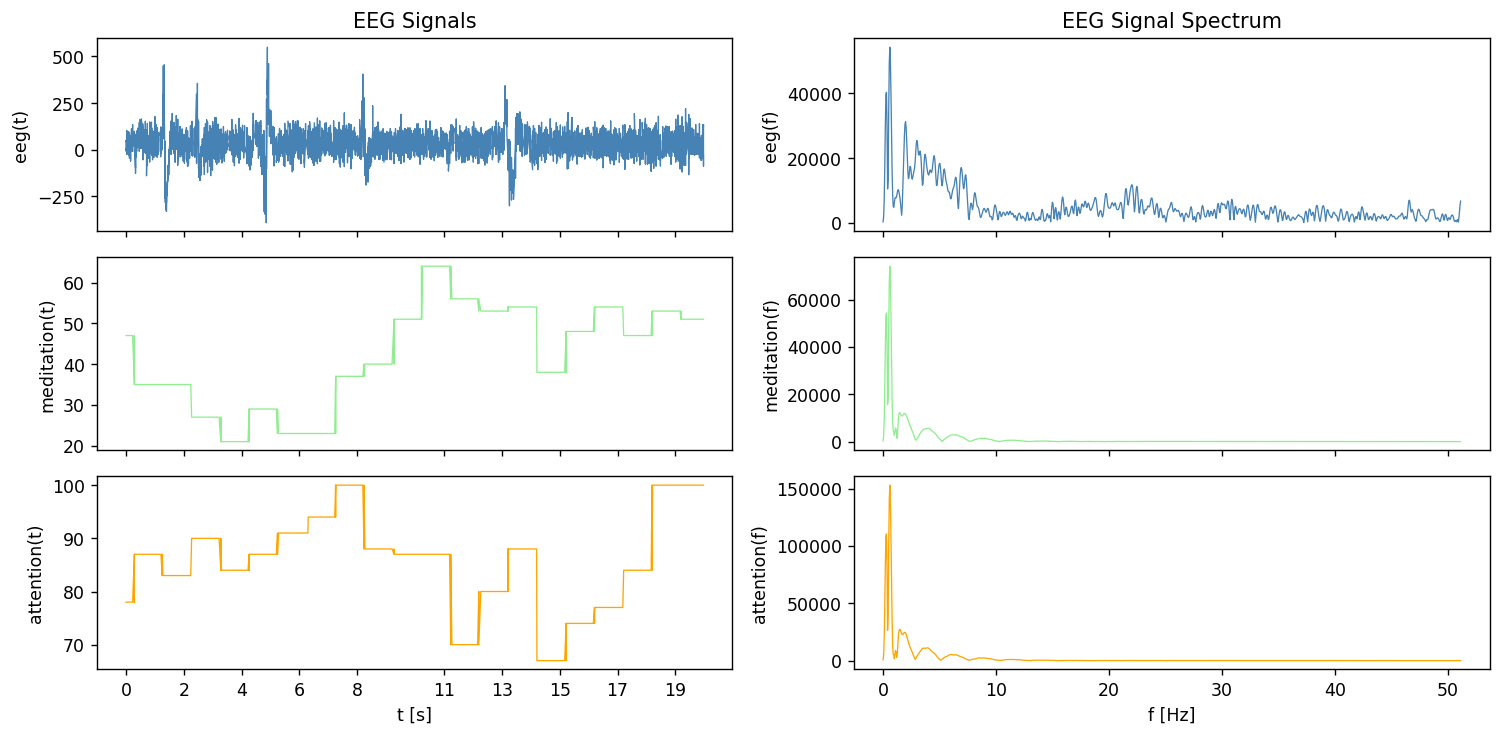

After labelling - signals (26586, 9) | labeled (312715, 9)


In [253]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="blinking", delta=timedelta(seconds=20))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

### Final: **Blinking**

Before labelling - signals (26586, 9) | labeled (312715, 9)


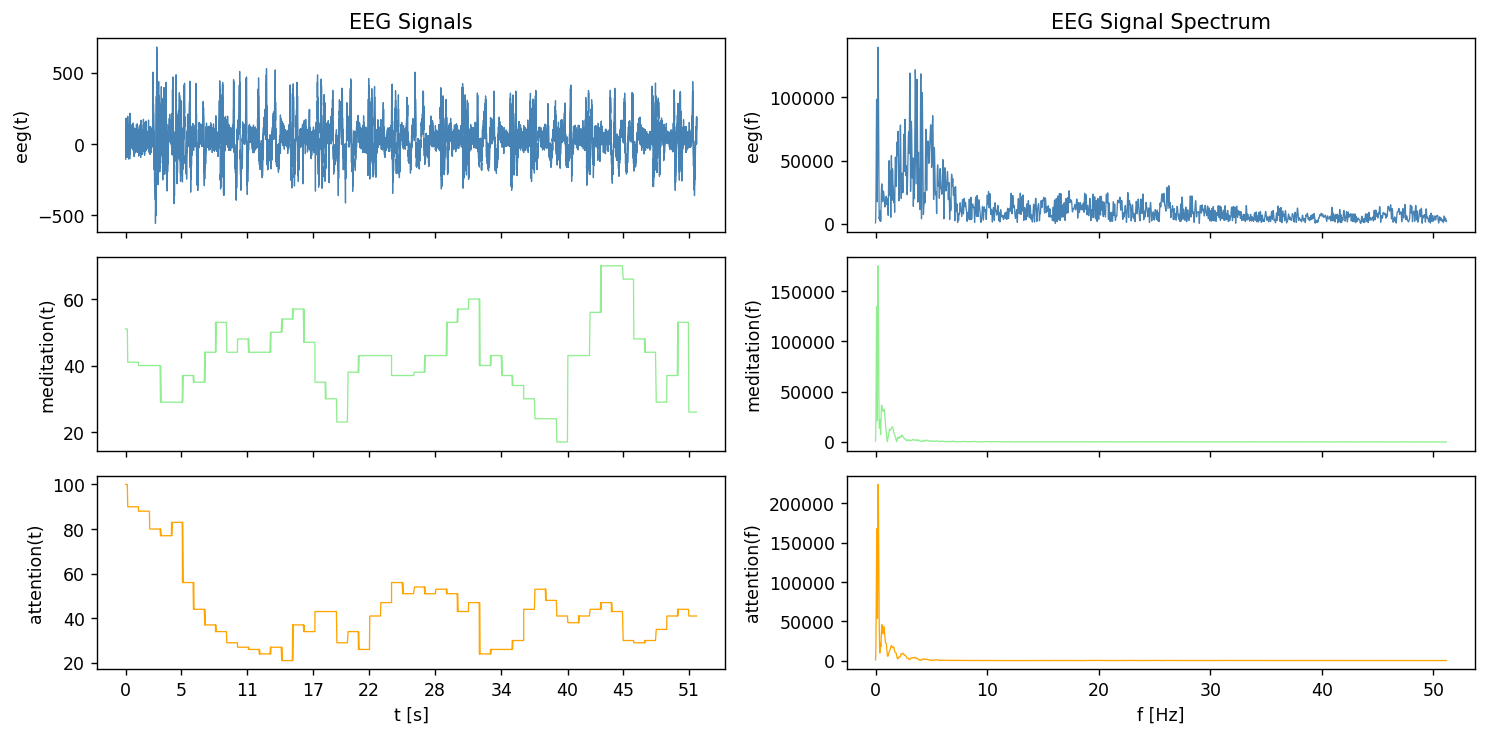

After labelling - signals (0, 9) | labeled (339301, 9)


In [254]:
print(f"Before labelling - signals {signals.shape} | labeled {labeled_signals.shape}")

label_records(label="blinking", delta=timedelta(minutes=2, seconds=23))

print(f"After labelling - signals {signals.shape} | labeled {labeled_signals.shape}")